## Groundwater recharge estimation using Earth Engine in California 

### We will go through 4 tasks to implement our project:

#### Task1:the Earth Engine python API will be initialized, some useful libraries will be installed & imported.

#### Task2:  OpenLandMap datasets related to soil properties will be explored. The wilting point and field capacity of the soil will be      calculated by applying some mathematical expressions to multiple images.


#### Task3:  evapotranspiration and precipitation datasets will be imported. A function will be defined to resample the time resolution of an ee.ImageCollection and to homogenize time index of both datasets. Both datasets will then be combined into one.

#### Task4: the Thornthwaite-Mather(TM) procedure will be implemented by iterating over the meteorological ee.ImageCollection. Finally, a comparison between groundwater recharge in two places ( Raisin City and Reefer City)  will be described and the resulting mean annual groundwater recharge will be displayed over California.

### Task1:the Earth Engine python API will be initialized, some useful libraries will be installed & imported.


In [1]:
# Install the API to  Python environment
#pip install earthengine-api --upgrade

In [2]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/1AfJohXnDHQYm87f2a1NoS9kWn63nqauBLygu0oLIcls0YJGr7GbGN3C0-zk

Successfully saved authorization token.


### install important libraries 

Folium :
conda install folium -c conda-forge

In [3]:
#pip install branca

In [4]:
#pip install PrettyPrinter

In [5]:
import pandas as pd  #data analysis (including the DataFrame data structure)
import matplotlib.pyplot as plt    #data visualization library
import numpy as np   #array-processing package
import folium        #interactive web map
import pprint        #a pretty printer
import branca.colormap as cm    #utility module for dealing with colormaps.

# Some input parameters

#### We additionally define some parameters used to evaluate the results of our implementation. Particularly:

    A-the period of interest to get meteorological records.
    B-a location of interest based on longitude and latitude coordinates. 
#### In the following, the point of interest is located in a productive agricultural region which is about 10 kilometers south of the city of Raisin (California). This point is used to evaluate and illustrate the progress of the described procedure.

In [6]:
# Initial date of interest (inclusive).
i_date = "2015-01-01"

# Final date of interest (exclusive).
f_date = "2020-01-01"

# Define the location of interest with a point.
lon = -119.93339
lat = 36.503175
poi = ee.Geometry.Point(lon, lat)

# A nominal scale in meters of the projection to work in [in meters].
scale = 1000

### Task2:  OpenLandMap datasets related to soil properties will be explored. The wilting point and field capacity of the soil will be      calculated by applying some mathematical expressions to multiple images.
 

In [7]:
# Soil depths [in cm] where we have data.
olm_depths = [0, 10, 30, 60, 100, 200]

# Names of bands associated with reference depths.
olm_bands = ["b" + str(sd) for sd in olm_depths]

##### define a function to get the ee.Image associated to the parameter we are interested in (e.g. sand, clay, organic carbon content, etc.).

In [8]:
def get_soil_prop(param):
    """
    This function returns soil properties image
    param (str): must be one of:
        "sand"     - Sand fraction
        "clay"     - Clay fraction
        "orgc"     - Organic Carbon fraction
    """
    if param == "sand":  # Sand fraction [%w]
        snippet = "OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M/v02"
        # Define the scale factor in accordance with the dataset description.
        scale_factor = 1 * 0.01

    elif param == "clay":  # Clay fraction [%w]
        snippet = "OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02"
        # Define the scale factor in accordance with the dataset description.
        scale_factor = 1 * 0.01

    elif param == "orgc":  # Organic Carbon fraction [g/kg]
        snippet = "OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02"
        # Define the scale factor in accordance with the dataset description.
        scale_factor = 5 * 0.001  # to get kg/kg
    else:
        return print("error")

    # Apply the scale factor to the ee.Image.
    dataset = ee.Image(snippet).multiply(scale_factor)

    return dataset

##### apply this function to import soil properties: 

In [9]:
# Image associated with the sand content.
sand = get_soil_prop("sand")

# Image associated with the clay content.
clay = get_soil_prop("clay")

# Image associated with the organic carbon content.
orgc = get_soil_prop("orgc")

##### To illustrate the result, we define a new method for handing Earth Engine tiles and using it to display the clay content of the soil at a given reference depth, to a Leaflet map.

In [10]:

def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict["tile_fetcher"].url_format,
        attr="Map Data &copy; <a href='https://earthengine.google.com/'>Google Earth Engine</a>",
        name=name,
        overlay=True,
        control=True,
    ).add_to(self)


# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

my_map = folium.Map(location=[lat, lon], zoom_start=3)

# Set visualization parameters.
vis_params = {
    "bands": ["b0"],
    "min": 0.01,
    "max": 1,
    "opacity": 1,
    "palette": ["white", "#464646"],
}

# Add the sand content data to the map object.
my_map.add_ee_layer(sand, vis_params, "Sand Content")

# Add a marker at the location of interest.
folium.Marker([lat, lon], popup="point of interest").add_to(my_map)

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)


##### Now, a function is defined to get soil properties at a given location. The following function returns a dictionary indicating the value of the parameter of interest for each standard depth (in centimeter). This function uses the ee.Image.sample method to evaluate the ee.Image properties on the region of interest. The result is then transferred client-side using the ee.Image.getInfo method. 

#####  the sand content

In [11]:
def local_profile(dataset, poi, buffer):
    # Get properties at the location of interest and transfer to client-side.
    prop = dataset.sample(poi, buffer).select(olm_bands).getInfo()

    # Selection of the features/properties of interest.
    profile = prop["features"][0]["properties"]

    # Re-shaping of the dict.
    profile = {key: round(val, 3) for key, val in profile.items()}

    return profile


# Apply the function to get the sand profile.
profile_sand = local_profile(sand, poi, scale)

# Print the result.
print("Sand content profile at the location of interest:\n", profile_sand)

Sand content profile at the location of interest:
 {'b0': 0.5, 'b10': 0.49, 'b100': 0.5, 'b200': 0.55, 'b30': 0.49, 'b60': 0.49}


##### We now apply the function to plot the profile of the soil regarding sand and clay and organic carbon content at the location of interest: 

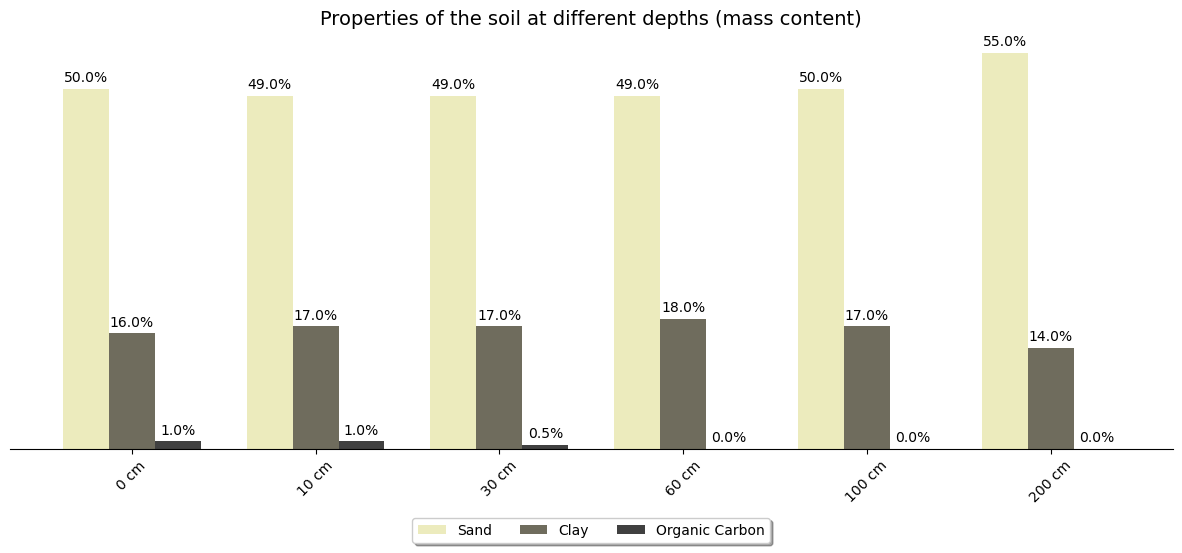

In [12]:
# Clay and organic content profiles.
profile_clay = local_profile(clay, poi, scale)
profile_orgc = local_profile(orgc, poi, scale)

# Data visualization in the form of a bar plot.
fig, ax = plt.subplots(figsize=(15, 6))
ax.axes.get_yaxis().set_visible(False)

# Definition of label locations.
x = np.arange(len(olm_bands))

# Definition of the bar width.
width = 0.25

# Bar plot representing the sand content profile.
rect1 = ax.bar(
    x - width,
    [round(100 * profile_sand[b], 2) for b in olm_bands],
    width,
    label="Sand",
    color="#ecebbd",
)

# Bar plot representing the clay content profile.
rect2 = ax.bar(
    x,
    [round(100 * profile_clay[b], 2) for b in olm_bands],
    width,
    label="Clay",
    color="#6f6c5d",
)

# Bar plot representing the organic carbon content profile.
rect3 = ax.bar(
    x + width,
    [round(100 * profile_orgc[b], 2) for b in olm_bands],
    width,
    label="Organic Carbon",
    color="black",
    alpha=0.75,
)

# Definition of a function to attach a label to each bar.
def autolabel_soil_prop(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "{}".format(height) + "%",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset.
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=10,
        )


# Application of the function to each barplot.
autolabel_soil_prop(rect1)
autolabel_soil_prop(rect2)
autolabel_soil_prop(rect3)

# Title of the plot.
ax.set_title("Properties of the soil at different depths (mass content)", fontsize=14)

# Properties of x/y labels and ticks.
ax.set_xticks(x)
x_labels = [str(d) + " cm" for d in olm_depths]
ax.set_xticklabels(x_labels, rotation=45, fontsize=10)

ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Shrink current axis's height by 10% on the bottom.
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# Add a legend below current axis.
ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3
)

plt.show()

#### Note that in the equation of Saxton & Rawls (2006), the wilting point and field capacity are calculated using the Organic Matter content (OM) and not the Organic Carbon content (OC). In the following, we convert OC into OM using the corrective factor known as the Van Bemmelen factor:


##### OM=1.724×OC 



In [13]:
# Conversion of organic carbon content into organic matter content.
orgm = orgc.multiply(1.724)

# Organic matter content profile.
profile_orgm = local_profile(orgm, poi, scale)
print("Organic Matter content profile at the location of interest:\n", profile_orgm)

Organic Matter content profile at the location of interest:
 {'b0': 0.017, 'b10': 0.017, 'b100': 0, 'b200': 0, 'b30': 0.009, 'b60': 0}


##### The mathematical expression is applied as follows to determine wilting point and field capacity:



In [14]:
# Initialization of two constant images for wilting point and field capacity.
wilting_point = ee.Image(0)
field_capacity = ee.Image(0)

# Calculation for each standard depth using a loop.
for key in olm_bands:
    # Getting sand, clay and organic matter at the appropriate depth.
    si = sand.select(key)
    ci = clay.select(key)
    oi = orgm.select(key)

    # Calculation of the wilting point.
    # The theta_1500t parameter is needed for the given depth.
    theta_1500ti = (
        ee.Image(0)
        .expression(
            "-0.024 * S + 0.487 * C + 0.006 * OM + 0.005 * (S * OM)\
        - 0.013 * (C * OM) + 0.068 * (S * C) + 0.031",
            {
                "S": si,
                "C": ci,
                "OM": oi,
            },
        )
        .rename("T1500ti")
    )

    # Final expression for the wilting point.
    wpi = theta_1500ti.expression(
        "T1500ti + ( 0.14 * T1500ti - 0.002)", {"T1500ti": theta_1500ti}
    ).rename("wpi")

    # Add as a new band of the global wilting point ee.Image.
    # Do not forget to cast the type with float().
    wilting_point = wilting_point.addBands(wpi.rename(key).float())

    # Same process for the calculation of the field capacity.
    # The parameter theta_33t is needed for the given depth.
    theta_33ti = (
        ee.Image(0)
        .expression(
            "-0.251 * S + 0.195 * C + 0.011 * OM +\
        0.006 * (S * OM) - 0.027 * (C * OM)+\
        0.452 * (S * C) + 0.299",
            {
                "S": si,
                "C": ci,
                "OM": oi,
            },
        )
        .rename("T33ti")
    )

    # Final expression for the field capacity of the soil.
    fci = theta_33ti.expression(
        "T33ti + (1.283 * T33ti * T33ti - 0.374 * T33ti - 0.015)",
        {"T33ti": theta_33ti.select("T33ti")},
    )

    # Add a new band of the global field capacity ee.Image.
    field_capacity = field_capacity.addBands(fci.rename(key).float())

##### the result around our location of interest:

In [15]:
profile_wp = local_profile(wilting_point, poi, scale)
profile_fc = local_profile(field_capacity, poi, scale)

print("Wilting point profile:\n", profile_wp)
print("Field capacity profile:\n", profile_fc)

Wilting point profile:
 {'b0': 0.121, 'b10': 0.127, 'b100': 0.12, 'b200': 0.096, 'b30': 0.127, 'b60': 0.121}
Field capacity profile:
 {'b0': 0.218, 'b10': 0.223, 'b100': 0.213, 'b200': 0.181, 'b30': 0.225, 'b60': 0.218}


##### The result is displayed using barplots


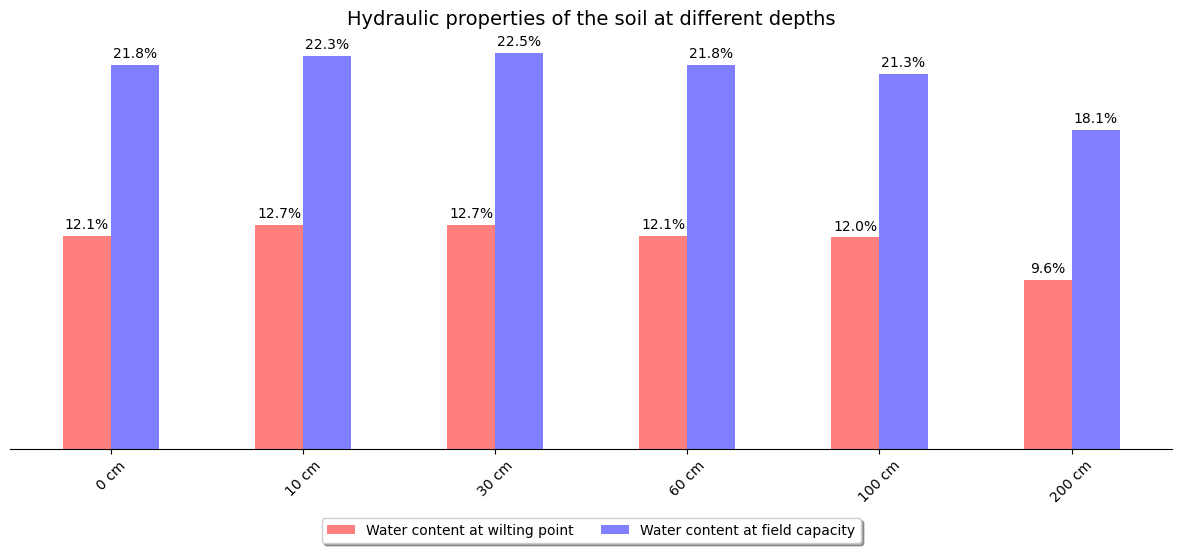

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.axes.get_yaxis().set_visible(False)

# Definition of the label locations.
x = np.arange(len(olm_bands))

# Width of the bar of the barplot.
width = 0.25

# Barplot associated with the water content at the wilting point.
rect1 = ax.bar(
    x - width / 2,
    [round(profile_wp[b] * 100, 2) for b in olm_bands],
    width,
    label="Water content at wilting point",
    color="red",
    alpha=0.5,
)

# Barplot associated with the water content at the field capacity.
rect2 = ax.bar(
    x + width / 2,
    [round(profile_fc[b] * 100, 2) for b in olm_bands],
    width,
    label="Water content at field capacity",
    color="blue",
    alpha=0.5,
)

# Add Labels on top of bars.
autolabel_soil_prop(rect1)
autolabel_soil_prop(rect2)

# Title of the plot.
ax.set_title("Hydraulic properties of the soil at different depths", fontsize=14)

# Properties of x/y labels and ticks.
ax.set_xticks(x)
x_labels = [str(d) + " cm" for d in olm_depths]
ax.set_xticklabels(x_labels, rotation=45, fontsize=10)

ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Shrink current axis's height by 10% on the bottom.
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# Put a legend below current axis.
ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2
)

plt.show()

### Task3:  evapotranspiration and precipitation datasets will be imported. A function will be defined to resample the time resolution of an ee.ImageCollection and to homogenize time index of both datasets. Both datasets will then be combined into one.

The meteorological data used in our implementation of the TM procedure relies on the following datasets:

- Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS) gives precipitations on a daily basis (resolution of 5 km),
- MODIS Terra Net gives evapotranspiration on a 8-days basis (resolution of 500 m).

In [17]:
# Import precipitation.
pr = (
    ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
    .select("precipitation")
    .filterDate(i_date, f_date)
)

# Import potential evaporation PET and its quality indicator ET_QC.
pet = (
    ee.ImageCollection("MODIS/006/MOD16A2")
    .select(["PET", "ET_QC"])
    .filterDate(i_date, f_date)
)

#### have a closer look around our location of interest. 

In [18]:
# Evaluate local precipitation conditions.
local_pr = pr.getRegion(poi, scale).getInfo()
pprint.pprint(local_pr[:5])

[['id', 'longitude', 'latitude', 'time', 'precipitation'],
 ['20150101', -119.92958200637672, 36.50304157019676, 1420070400000, 0],
 ['20150102', -119.92958200637672, 36.50304157019676, 1420156800000, 0],
 ['20150103', -119.92958200637672, 36.50304157019676, 1420243200000, 0],
 ['20150104', -119.92958200637672, 36.50304157019676, 1420329600000, 0]]


##### establish a procedure to get meteorological data around a given location in form of a pandas.DataFrame:



In [19]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors="coerce")

    # Convert the time field into a datetime.
    df["datetime"] = pd.to_datetime(df["time"], unit="ms")

    # Keep the columns of interest.
    df = df[["time", "datetime", *list_of_bands]]

    # The datetime column is defined as index.
    df = df.set_index("datetime")

    return df

###### apply the function and see the head of precipitation 

In [20]:
pr_df = ee_array_to_df(local_pr, ["precipitation"])
pr_df.head()

,time,precipitation
datetime,,
2015-01-01,1420070400000,0.0
2015-01-02,1420156800000,0.0
2015-01-03,1420243200000,0.0
2015-01-04,1420329600000,0.0
2015-01-05,1420416000000,0.0


###### apply the function and see the head of potential evaporation

In [21]:
# Evaluate local potential evapotranspiration.
local_pet = pet.getRegion(poi, scale).getInfo()

# Transform the result into a pandas dataframe.
pet_df = ee_array_to_df(local_pet, ["PET", "ET_QC"])
pet_df.head()

,time,PET,ET_QC
datetime,,,
2015-01-01,1420070400000,NaN,16
2015-01-09,1420761600000,NaN,8
2015-01-17,1421452800000,NaN,105
2015-01-25,1422144000000,NaN,8
2015-02-02,1422835200000,246.0,16


Looking at both pandas.DataFrame shows the following points:

- the time resolution between both datasets is not the same,
- for some reasons, potential evapotranspiration cannot be calculated at some dates. 

#### Resampling the time resolution of an ee.ImageCollection
 

##### To address these issues (homogeneous time index and missing values), we make a sum resampling of both datasets by month. When PET cannot be calculated, the monthly averaged value is considered. The key steps and functions used to resample are described below:

- A new date index is defined as a sequence using the ee.List.sequence method.

- A function representing the resampling operation is defined. This function consists of grouping images of the desired time interval and calculating the sum. The sum is calculated by taking the mean between available images and multiplying it by the duration of the interval.

- The user-supplied function is then mapped over the new time index using .map().


In [22]:
def sum_resampler(coll, freq, unit, scale_factor, band_name):
    """
    This function aims to resample the time scale of an ee.ImageCollection.
    The function returns an ee.ImageCollection with the averaged sum of the
    band on the selected frequency.
    coll: (ee.ImageCollection) only one band can be handled
    freq: (int) corresponds to the resampling frequence
    unit: (str) corresponds to the resampling time unit.
                must be 'day', 'month' or 'year'
    scale_factor (float): scaling factor used to get our value in the good unit
    band_name (str) name of the output band
    """

    # Define initial and final dates of the collection.
    firstdate = ee.Date(
        coll.sort("system:time_start", True).first().get("system:time_start")
    )

    lastdate = ee.Date(
        coll.sort("system:time_start", False).first().get("system:time_start")
    )

    # Calculate the time difference between both dates.
    # https://developers.google.com/earth-engine/apidocs/ee-date-difference
    diff_dates = lastdate.difference(firstdate, unit)

    # Define a new time index (for output).
    new_index = ee.List.sequence(0, ee.Number(diff_dates), freq)

    # Define the function that will be applied to our new time index.
    def apply_resampling(date_index):
        # Define the starting date to take into account.
        startdate = firstdate.advance(ee.Number(date_index), unit)

        # Define the ending date to take into account according
        # to the desired frequency.
        enddate = firstdate.advance(ee.Number(date_index).add(freq), unit)

        # Calculate the number of days between starting and ending days.
        diff_days = enddate.difference(startdate, "day")

        # Calculate the composite image.
        image = (
            coll.filterDate(startdate, enddate)
            .mean()
            .multiply(diff_days)
            .multiply(scale_factor)
            .rename(band_name)
        )

        # Return the final image with the appropriate time index.
        return image.set("system:time_start", startdate.millis())

    # Map the function to the new time index.
    res = new_index.map(apply_resampling)

    # Transform the result into an ee.ImageCollection.
    res = ee.ImageCollection(res)

    return res

#### The precipitation dataset is now resampled by month as follows:

- the collection to resample is defined as pr,

- we want a collection on a monthly basis then freq = 1 and unit = "month",

- there is no correction factor to apply according to the dataset description then scale_factor = 1,

- "pr" is the name of the output band. 

In [23]:
# Apply the resampling function to the precipitation dataset.
pr_m = sum_resampler(pr, 1, "month", 1, "pr")

# Evaluate the result at the location of interest.
pprint.pprint(pr_m.getRegion(poi, scale).getInfo()[:5])

[['id', 'longitude', 'latitude', 'time', 'pr'],
 ['0',
  -119.92958200637672,
  36.50304157019676,
  1420070400000,
  9.153860449790955],
 ['1', -119.92958200637672, 36.50304157019676, 1422748800000, 20.9977068901062],
 ['2',
  -119.92958200637672,
  36.50304157019676,
  1425168000000,
  22.75502449274063],
 ['3',
  -119.92958200637672,
  36.50304157019676,
  1427846400000,
  21.643964052200317]]


##### For evapotranspiration, we have to be careful with the unit. The dataset gives us an 8-day sum and a scale factor of 10 is applied. Then, to get a homogeneous unit, we need to rescale by dividing by 8 and 10:

 

In [24]:
# Apply the resampling function to the PET dataset.
pet_m = sum_resampler(pet.select("PET"), 1, "month", 0.0125, "pet")

# Evaluate the result at the location of interest.
pprint.pprint(pet_m.getRegion(poi, scale).getInfo()[:5])

[['id', 'longitude', 'latitude', 'time', 'pet'],
 ['0', -119.92958200637672, 36.50304157019676, 1420070400000, None],
 ['1', -119.92958200637672, 36.50304157019676, 1422748800000, 94.15],
 ['2', -119.92958200637672, 36.50304157019676, 1425168000000, 164.009375],
 ['3', -119.92958200637672, 36.50304157019676, 1427846400000, 187.25]]


##### We now combine both ee.ImageCollection objects (pet_m and pr_m) using the ee.ImageCollection.combine method. Note that corresponding images in both ee.ImageCollection objects need to have the same time index before combining. 

In [25]:
# Combine precipitation and evapotranspiration.
meteo = pr_m.combine(pet_m)

# Import meteorological data as an array at the location of interest.
meteo_arr = meteo.getRegion(poi, scale).getInfo()

# Print the result.
pprint.pprint(meteo_arr[:5])

[['id', 'longitude', 'latitude', 'time', 'pr', 'pet'],
 ['0',
  -119.92958200637672,
  36.50304157019676,
  1420070400000,
  9.153860449790955,
  None],
 ['1',
  -119.92958200637672,
  36.50304157019676,
  1422748800000,
  20.9977068901062,
  94.15],
 ['10',
  -119.92958200637672,
  36.50304157019676,
  1446336000000,
  18.700965642929077,
  90.75],
 ['11',
  -119.92958200637672,
  36.50304157019676,
  1448928000000,
  42.84603822231293,
  61.128125000000004]]


#### We evaluate the result on our location of interest:



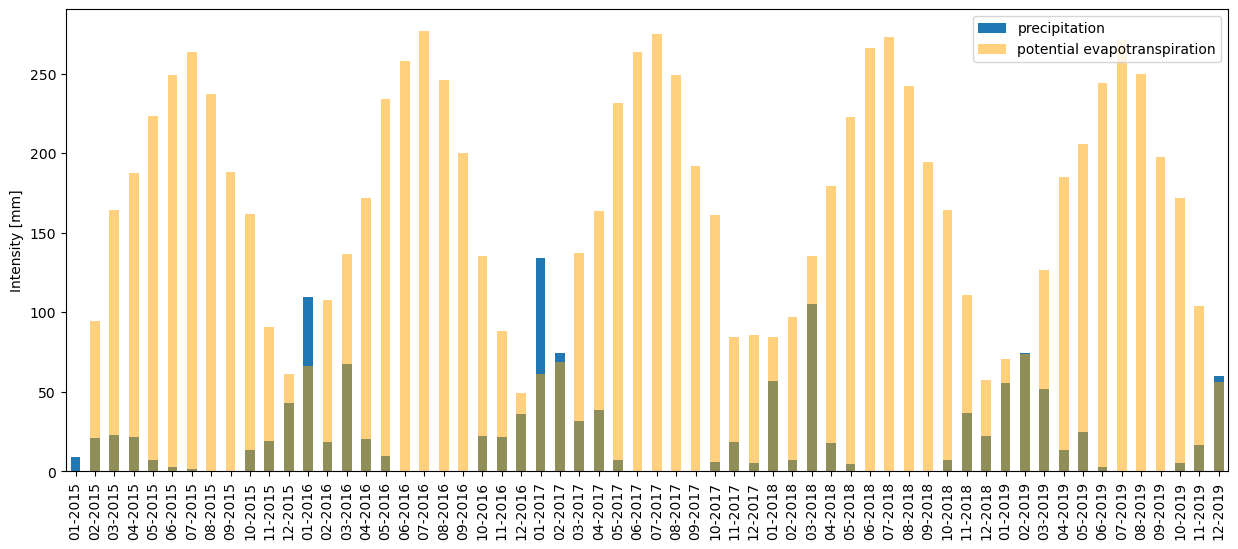

In [26]:
# Transform the array into a pandas dataframe and sort the index.
meteo_df = ee_array_to_df(meteo_arr, ["pr", "pet"]).sort_index()

# Data visualization
fig, ax = plt.subplots(figsize=(15, 6))

# Barplot associated with precipitations.
meteo_df["pr"].plot(kind="bar", ax=ax, label="precipitation")

# Barplot associated with potential evapotranspiration.
meteo_df["pet"].plot(
    kind="bar", ax=ax, label="potential evapotranspiration", color="orange", alpha=0.5
)

# Add a legend.
ax.legend()

# Add some x/y-labels properties.
ax.set_ylabel("Intensity [mm]")
ax.set_xlabel(None)

# Define the date format and shape of x-labels.
x_labels = meteo_df.index.strftime("%m-%Y")
ax.set_xticklabels(x_labels, rotation=90, fontsize=10)

plt.show()

### Task4: the Thornthwaite-Mather(TM) procedure will be implemented by iterating over the meteorological ee.ImageCollection. Finally, a comparison between groundwater recharge in two places will be described and the resulting mean annual groundwater recharge will be displayed over California.

###### According to this global dataset, the effective rooting depth around our region of interest (France) can reasonably assumed to Zr=0.5. Additionally, the parameter p is also assumed constant and equal to and p=0.5 which is in line with common values described in Table 22 of Allen et al. (1998).

In [27]:
zr = ee.Image(0.5)
p = ee.Image(0.5)

##### we also consider an averaged value between reference depths of the water content at wilting point and field capacity: 

In [28]:
def olm_prop_mean(olm_image, band_output_name):
    """
    This function calculates an averaged value of
    soil properties between reference depths.
    """
    mean_image = olm_image.expression(
        "(b0 + b10 + b30 + b60 + b100 + b200) / 6",
        {
            "b0": olm_image.select("b0"),
            "b10": olm_image.select("b10"),
            "b30": olm_image.select("b30"),
            "b60": olm_image.select("b60"),
            "b100": olm_image.select("b100"),
            "b200": olm_image.select("b200"),
        },
    ).rename(band_output_name)

    return mean_image


# Apply the function to field capacity and wilting point.
fcm = olm_prop_mean(field_capacity, "fc_mean")
wpm = olm_prop_mean(wilting_point, "wp_mean")

# Calculate the theoretical available water.
taw = (
    (fcm.select("fc_mean").subtract(wpm.select("wp_mean"))).multiply(1000).multiply(zr)
)

# Calculate the stored water at the field capacity.
stfc = taw.multiply(p)

#### Initialization
##### The initial time of the calculation is defined according to the first date of the meteorological collection:

In [29]:
# Define the initial time (time0) according to the start of the collection.
time0 = meteo.first().get("system:time_start")

###### Then, we initialize the calculation with an ee.Image where all bands associated to the hydric state of the soil are set equal to ee.Image(0), except for the initial storage which is considered to be equal to the water content at field capacity, meaning that  ST0=STFC 

In [30]:
# Initialize all bands describing the hydric state of the soil.
# Do not forget to cast the type of the data with a .float().
# Initial recharge.
initial_rech = ee.Image(0).set("system:time_start", time0).select([0], ["rech"]).float()

# Initialization of APWL.
initial_apwl = ee.Image(0).set("system:time_start", time0).select([0], ["apwl"]).float()

# Initialization of ST.
initial_st = stfc.set("system:time_start", time0).select([0], ["st"]).float()

# Initialization of precipitation.
initial_pr = ee.Image(0).set("system:time_start", time0).select([0], ["pr"]).float()

# Initialization of potential evapotranspiration.
initial_pet = ee.Image(0).set("system:time_start", time0).select([0], ["pet"]).float()

##### combine all these bands into one ee.Image adding new bands to the first using the ee.Image.addBands method:

In [31]:
initial_image = initial_rech.addBands(
    ee.Image([initial_apwl, initial_st, initial_pr, initial_pet])
)

##### We also initialize a list in which new images will be added after each iteration. We create this server-side list using the ee.List method.

In [32]:
image_list = ee.List([initial_image])

### Iteration over an ee.ImageCollection
 

##### The function we apply to each element of the meteorological dataset to calculate groundwater recharge is defined as follows.



In [33]:
def recharge_calculator(image, image_list):
    """
    Contains operations made at each iteration.
    """
    # Determine the date of the current ee.Image of the collection.
    localdate = image.date().millis()

    # Import previous image stored in the list.
    prev_im = ee.Image(ee.List(image_list).get(-1))

    # Import previous APWL and ST.
    prev_apwl = prev_im.select("apwl")
    prev_st = prev_im.select("st")

    # Import current precipitation and evapotranspiration.
    pr_im = image.select("pr")
    pet_im = image.select("pet")

    # Initialize the new bands associated with recharge, apwl and st.
    # DO NOT FORGET TO CAST THE TYPE WITH .float().
    new_rech = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["rech"])
        .float()
    )

    new_apwl = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["apwl"])
        .float()
    )

    new_st = (
        prev_st.set("system:time_start", localdate).select([0], ["st"]).float()
    )

    # Calculate bands depending on the situation using binary layers with
    # logical operations.

    # CASE 1.
    # Define zone1: the area where PET > P.
    zone1 = pet_im.gt(pr_im)

    # Calculation of APWL in zone 1.
    zone1_apwl = prev_apwl.add(pet_im.subtract(pr_im)).rename("apwl")
    # Implementation of zone 1 values for APWL.
    new_apwl = new_apwl.where(zone1, zone1_apwl)

    # Calculate ST in zone 1.
    zone1_st = prev_st.multiply(
        ee.Image.exp(zone1_apwl.divide(stfc).multiply(-1))
    ).rename("st")
    # Implement ST in zone 1.
    new_st = new_st.where(zone1, zone1_st)

    # CASE 2.
    # Define zone2: the area where PET <= P.
    zone2 = pet_im.lte(pr_im)

    # Calculate ST in zone 2.
    zone2_st = prev_st.add(pr_im).subtract(pet_im).rename("st")
    # Implement ST in zone 2.
    new_st = new_st.where(zone2, zone2_st)

    # CASE 2.1.
    # Define zone21: the area where PET <= P and ST >= STfc.
    zone21 = zone2.And(zone2_st.gte(stfc))

    # Calculate recharge in zone 21.
    zone21_re = zone2_st.subtract(stfc).rename("rech")
    # Implement recharge in zone 21.
    new_rech = new_rech.where(zone21, zone21_re)
    # Implement ST in zone 21.
    new_st = new_st.where(zone21, stfc)

    # CASE 2.2.
    # Define zone 22: the area where PET <= P and ST < STfc.
    zone22 = zone2.And(zone2_st.lt(stfc))

    # Calculate APWL in zone 22.
    zone22_apwl = (
        stfc.multiply(-1).multiply(ee.Image.log(zone2_st.divide(stfc))).rename("apwl")
    )
    # Implement APWL in zone 22.
    new_apwl = new_apwl.where(zone22, zone22_apwl)

    # Create a mask around area where recharge can effectively be calculated.
    # Where we have have PET, P, FCm, WPm (except urban areas, etc.).
    mask = pet_im.gte(0).And(pr_im.gte(0)).And(fcm.gte(0)).And(wpm.gte(0))

    # Apply the mask.
    new_rech = new_rech.updateMask(mask)

    # Add all Bands to our ee.Image.
    new_image = new_rech.addBands(ee.Image([new_apwl, new_st, pr_im, pet_im]))

    # Add the new ee.Image to the ee.List.
    return ee.List(image_list).add(new_image)

#### The TM procedure can now be applied to the meteorological ee.ImageCollection:

In [34]:
# Iterate the user-supplied function to the meteo collection.
rech_list = meteo.iterate(recharge_calculator, image_list)

# Remove the initial image from our list.
rech_list = ee.List(rech_list).remove(initial_image)

# Transform the list into an ee.ImageCollection.
rech_coll = ee.ImageCollection(rech_list)


### Let’s have a look at the result around the location of interest:



In [35]:
arr = rech_coll.getRegion(poi, scale).getInfo()
rdf = ee_array_to_df(arr, ["pr", "pet", "apwl", "st", "rech"]).sort_index()
rdf.head(12)

,time,pr,pet,apwl,st,rech
datetime,,,,,,
2015-01-01,1420070400000,9.153860,NaN,0.000000,2.359778e+01,NaN
2015-02-01,1422748800000,20.997707,94.150000,73.152293,1.063098e+00,0.0
2015-03-01,1425168000000,22.755024,164.009375,1456.477718,9.518049e-105,0.0
2015-04-01,1427846400000,21.643964,187.250000,883.667173,2.226106e-43,0.0
2015-05-01,1430438400000,6.943823,223.200000,2426.275287,0.000000e+00,0.0
2015-06-01,1433116800000,2.881702,248.906250,327.678959,6.910070e-07,0.0
2015-07-01,1435708800000,1.151226,263.596875,305.667279,8.951687e-06,0.0
2015-08-01,1438387200000,0.000000,237.343750,543.011029,9.084624e-16,0.0
2015-09-01,1441065600000,0.000000,188.156250,731.167279,3.175949e-29,0.0


##### The result can be displayed in the form of a barplot as follows:



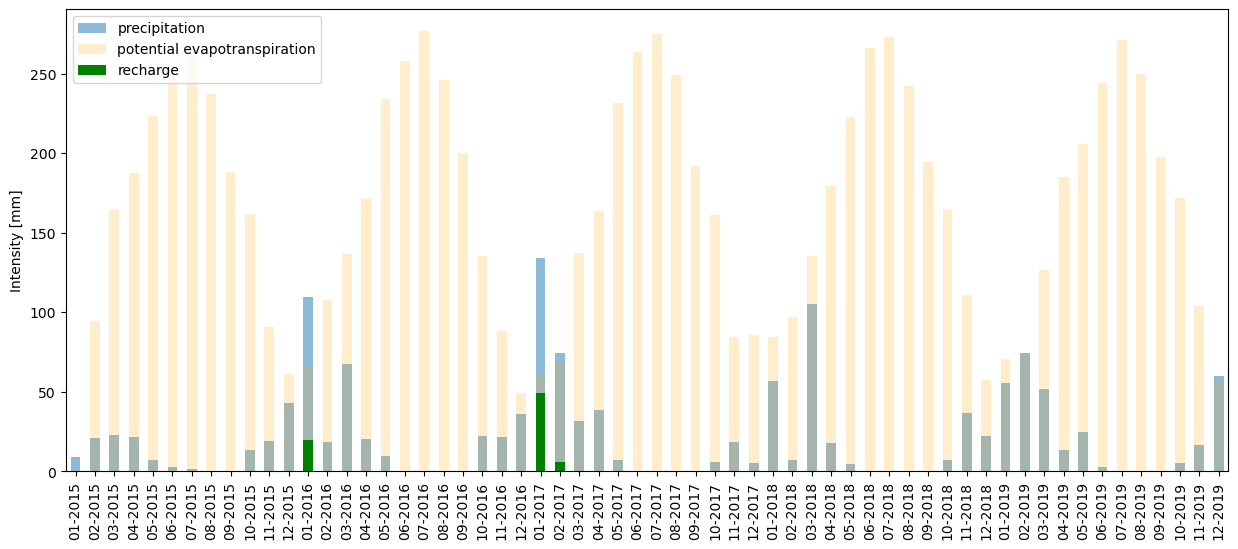

In [36]:
# Data visualization in the form of barplots.
fig, ax = plt.subplots(figsize=(15, 6))

# Barplot associated with precipitation.
rdf["pr"].plot(kind="bar", ax=ax, label="precipitation", alpha=0.5)

# Barplot associated with potential evapotranspiration.
rdf["pet"].plot(
    kind="bar", ax=ax, label="potential evapotranspiration", color="orange", alpha=0.2
)

# Barplot associated with groundwater recharge
rdf["rech"].plot(kind="bar", ax=ax, label="recharge", color="green", alpha=1)

# Add a legend.
ax.legend()

# Define x/y-labels properties.
ax.set_ylabel("Intensity [mm]")
ax.set_xlabel(None)

# Define the date format and shape of x-labels.
x_labels = rdf.index.strftime("%m-%Y")
ax.set_xticklabels(x_labels, rotation=90, fontsize=10)

plt.show()

The result shows the distribution of precipitation, potential evapotranspiration, and groundwater recharge along the year. It shows that in our area of interest(Raisin City) suffer from water scarcity, groundwater recharge not permanant every year and if it occurs, it is from January to february. Even though a amount of precipitation occurs from October to May. evapotranspiration largely dominates because of high temperatures and sun exposure during these months. The result is that no percolation into aquifers occurs during this period.

#### Now the annual average recharge over the period of interest can be calculated. To do that, we resample the DataFrame we’ve just created:



In [37]:
# Resample the pandas dataframe on a yearly basis making the sum by year.
rdfy = rdf.resample("Y").sum()

# Calculate the mean value.
mean_recharge = rdfy["rech"].mean()

# Print the result.
print(
    "The mean annual recharge at our point of interest is", int(mean_recharge), "mm/an"
)

The mean annual recharge at our point of interest is 14 mm/an


C:\Users\hesha\AppData\Local\Temp\ipykernel_1700\1140476268.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdfy = rdf.resample("Y").sum()


#### The mean annual recharge at our point of interest is 14 mm/an
 

# Groundwater recharge comparison between multiple places in California


#### Let’s define a function to get the local information based on the ee.ImageCollection we’ve just built:



In [38]:
def get_local_recharge(i_date, f_date, lon, lat, scale):
    """
    Returns a pandas df describing the cumulative groundwater
    recharge by month
    """
    # Define the location of interest with a point.
    poi = ee.Geometry.Point(lon, lat)

    # Evaluate the recharge around the location of interest.
    rarr = rech_coll.filterDate(i_date, f_date).getRegion(poi, scale).getInfo()

    # Transform the result into a pandas dataframe.
    rdf = ee_array_to_df(rarr, ["pr", "pet", "apwl", "st", "rech"]).sort_index()
    return rdf

##### We now use this function on a second point of interest located near the city of Reefer (california). This city is located in the south of France, and precipitation and groundwater recharge are expected to be much lower than in the previous case.

 

In [39]:
# Define the second location of interest by longitude/latitude.
lon2 = -118.197
lat2 = 35.006

# Calculate the local recharge condition at this location.
rdf2 = get_local_recharge(i_date, f_date, lon2, lat2, scale)

# Resample the resulting pandas dataframe on a yearly basis (sum by year).
rdf2y = rdf2.resample("Y").sum()
rdf2y.head()

C:\Users\hesha\AppData\Local\Temp\ipykernel_1700\2343640512.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rdf2y = rdf2.resample("Y").sum()


,pr,pet,apwl,st,rech
datetime,,,,,
2015-12-31,91.070120,2144.546875,21853.212910,3.014406e-01,0
2016-12-31,121.306101,2099.036458,17865.761592,1.657048e-27,0
2017-12-31,148.215938,2183.376042,43581.022076,0.000000e+00,0
2018-12-31,114.247306,2168.205208,71929.125000,0.000000e+00,0
2019-12-31,228.479812,2014.709375,88684.861479,2.510764e+00,0


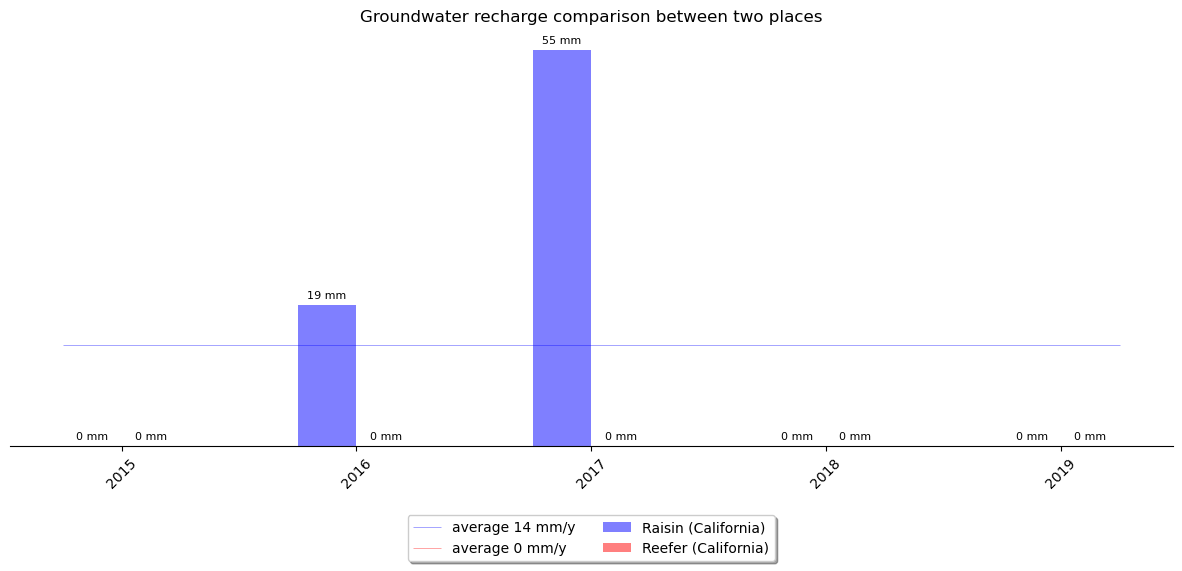

In [40]:
# Data Visualization
fig, ax = plt.subplots(figsize=(15, 6))
ax.axes.get_yaxis().set_visible(False)

# Define the x-label locations.
x = np.arange(len(rdfy))

# Define the bar width.
width = 0.25

# Bar plot associated to groundwater recharge at the 1st location of interest.
rect1 = ax.bar(
    x - width / 2, rdfy.rech, width, label="Raisin (California)", color="blue", alpha=0.5
)

# Bar plot associated to groundwater recharge at the 2nd location of interest.
rect2 = ax.bar(
    x + width / 2,
    rdf2y.rech,
    width,
    label="Reefer (California)",
    color="red",
    alpha=0.5,
)

# Define a function to attach a label to each bar.
def autolabel_recharge(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "{}".format(int(height)) + " mm",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8,
        )


autolabel_recharge(rect1)
autolabel_recharge(rect2)

# Calculate the averaged annual recharge at both locations of interest.
place1mean = int(rdfy["rech"].mean())
place2mean = int(rdf2y["rech"].mean())

# Add an horizontal line associated with averaged annual values (location 1).
ax.hlines(
    place1mean,
    xmin=min(x) - width,
    xmax=max(x) + width,
    color="blue",
    lw=0.5,
    label="average " + str(place1mean) + " mm/y",
    alpha=0.5,
)

# Add an horizontal line associated with averaged annual values (location 2).
ax.hlines(
    place2mean,
    xmin=min(x) - width,
    xmax=max(x) + width,
    color="red",
    lw=0.5,
    label="average " + str(place2mean) + " mm/y",
    alpha=0.5,
)

# Add a title.
ax.set_title("Groundwater recharge comparison between two places", fontsize=12)

# Define some x/y-axis properties.
ax.set_xticks(x)
x_labels = rdfy.index.year.tolist()
ax.set_xticklabels(x_labels, rotation=45, fontsize=10)

ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Shrink current axis's height by 10% on the bottom.
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# Add a legend below current axis.
ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2
)

plt.show()

The result shows that is no  annual recharge in Reefer.



# Groundwater recharge map of California


#### To get a map of groundwater recharge around our region of interest, let’s create a mean composite ee.Image based on our resulting ee.ImageCollection.

 

In [49]:
# Calculate the averaged annual recharge.
annual_rech = rech_coll.select("rech").mean().multiply(12)

# Calculate the average annual precipitation.
annual_pr = rech_coll.select("pr").mean().multiply(12)

# Get a feature collection of administrative boundaries.
countries = ee.FeatureCollection("FAO/GAUL/2015/level0").select("ADM0_NAME")

# Filter the feature collection to subset France.
United_States  = countries.filter(ee.Filter.eq("ADM0_NAME", "United States of America"))

# Clip the composite ee.Images around the region of interest.
rech_united_states = annual_rech.clip(United_States)
pr_united_states = annual_pr.clip(United_States)

#### the map can be drawn.

In [50]:
# Create a folium map.
my_map = folium.Map(location=[lat, lon], zoom_start=6, zoom_control=False)

# Set visualization parameters for recharge.
rech_vis_params = {
    "bands": "rech",
    "min": 0,
    "max": 500,
    "opacity": 1,
    "palette": ["red", "orange", "yellow", "green", "blue", "purple"],
}

# Set visualization parameters for precipitation.
pr_vis_params = {
    "bands": "pr",
    "min": 500,
    "max": 1500,
    "opacity": 1,
    "palette": ["white", "blue"],
}

# Define a recharge colormap.
rech_colormap = cm.LinearColormap(
    colors=rech_vis_params["palette"],
    vmin=rech_vis_params["min"],
    vmax=rech_vis_params["max"],
)

# Define a precipitation colormap.
pr_colormap = cm.LinearColormap(
    colors=pr_vis_params["palette"],
    vmin=pr_vis_params["min"],
    vmax=pr_vis_params["max"],
)

# Caption of the recharge colormap.
rech_colormap.caption = "Average annual recharge rate (mm/year)"

# Caption of the precipitation colormap.
pr_colormap.caption = "Average annual precipitation rate (mm/year)"

# Add the precipitation composite to the map object.
my_map.add_ee_layer(pr_united_states, pr_vis_params, "Precipitation")

# Add the recharge composite to the map object.
my_map.add_ee_layer(rech_united_states, rech_vis_params, "Recharge")

# Add a marker at both locations of interest.
folium.Marker([lat, lon], popup="Area of Raisin").add_to(my_map)
folium.Marker([lat2, lon2], popup="Area of Reefer").add_to(my_map)

# Add the colormaps to the map.
my_map.add_child(rech_colormap)
my_map.add_child(pr_colormap)

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)



# Please note the following points:



## - The procedure described in this tutorial does not consider the terrain slope which has a strong influence on runoff, especially in areas with significant relief. In these areas, groundwater recharge is overestimated because runoff is not considered.



## - The recharge calculation can be highly influenced by missing precipitation or potential evapotranspiration values. This issue is partially addressed by the dataset resampling procedure, but missing value can still exist and this point must be checked before considering that the calculated recharge is representative and reliable.